## Giving google colab access to google drive 
Only needed if you are using google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Guide
If you are useing google colab you will need to connect the google drive above. (Only needs to be done ones)

After that you will need to run the setup code to make the predication environment.

After everthing has been setup you will find the predict image options at the botton as well as the GUI and imageg compatabilty function.

## Setup

In [1]:
# Importing necessary libraries
import os
import math
import warnings

# Suppressing warnings
warnings.filterwarnings("ignore")

# Importing plotting library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Importing utility functions
from tensorflow.keras.utils import to_categorical
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import tkinter as tk

# Importing image processing libraries
from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

# Importing model-related modules
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *

# Importing pre-trained model and preprocessing function
from keras.applications.densenet import DenseNet121, preprocess_input

## Finding the amount of breeds and total images

# Define the directory containing breed images
images_directory = "D:/Programming/archive/images/Images"

# Get a list of all breeds from the directory
breed_list = os.listdir(images_directory)

# Count the number of breeds
num_classes = len(breed_list)

# Count the total number of images for all breeds
n_total_images = 0
for breed in breed_list:
    # Get the path to the current breed directory
    breed_directory = os.path.join(images_directory, breed)
    # Count the number of images in the current breed directory
    n_images_in_breed = len(os.listdir(breed_directory))
    # Add the count to the total number of images
    n_total_images += n_images_in_breed

## Reformatting the images. Only run when need new images ##

def Image_Reform():
    %%time
    
    # Create a directory to store data if it doesn't exist
    data_dir = 'data'
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    
    # Create subdirectories for each breed
    for breed in breed_list:
        breed_dir = os.path.join(data_dir, breed)
        if not os.path.exists(breed_dir):
            os.mkdir(breed_dir)
    
    print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir(data_dir))))
    
    # Iterate through each breed directory and process images
    for breed in os.listdir(data_dir):
        breed_annotation_dir = os.path.join('D:/Programming/archive/annotations/Annotation', breed)
        breed_image_dir = os.path.join('D:/Programming/archive/images/Images', breed)
    
        # Iterate through each file in the breed's annotation directory
        for file in os.listdir(breed_annotation_dir):
            annotation_path = os.path.join(breed_annotation_dir, file)
            image_path = os.path.join(breed_image_dir, '{}.jpg'.format(file))
    
            # Open image and parse annotation XML
            img = Image.open(image_path)
            tree = ET.parse(annotation_path)
    
            # Extract bounding box coordinates
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
    
            # Crop, convert, and resize image
            cropped_img = img.crop((xmin, ymin, xmax, ymax))
            cropped_img = cropped_img.convert('RGB')
            cropped_img = cropped_img.resize((224, 224))
    
            # Save the processed image to the appropriate breed directory
            save_path = os.path.join(data_dir, breed, '{}.jpg'.format(file))
            cropped_img.save(save_path)

## Mapping the dataset

# Initialize dictionaries to store mappings
label_maps = {}
label_maps_rev = {}

# Iterate over the breed list and assign indices
for index, breed_name in enumerate(breed_list):
    # Map breed names to indices
    label_maps[breed_name] = index
    # Map indices to breed names
    label_maps_rev[index] = breed_name

## Function to display images

def show_dir_images(breed, n_to_show):
    # Set up figure size for displaying images
    plt.figure(figsize=(16, 16))
    
    # Define the directory where images of the specified breed are located
    img_dir = "D:/Programming/archive/images/Images/{}/".format(breed)
    
    # Get a list of image filenames in the specified directory, limited by n_to_show
    images = os.listdir(img_dir)[:n_to_show]
    
    # Calculate the number of rows needed to display all images
    num_rows = math.ceil(n_to_show / 4)
    
    # Loop through the images and display them
    for i in range(n_to_show):
        # Read the image using matplotlib
        img = mpimg.imread(img_dir + images[i])
        
        # Create a subplot for the current image
        plt.subplot(num_rows, 4, i + 1)
        
        # Display the image
        plt.imshow(img)
        
        # Turn off axis labels
        plt.axis('off')

def paths_labels_and_targets():
    """
    Collects file paths, labels, and target values.
    """
    paths, labels, targets = [], [], []
    
    # Iterating through each breed and its respective images
    for breed in breed_list:
        base_name = f"./data/{breed}/"
        for img_name in os.listdir(base_name):
            paths.append(f"{base_name}{img_name}")  # Adding the file path
            labels.append(breed)  # Adding the breed label
            targets.append(label_maps[breed])  # Adding the target value
    
    return paths, labels, targets

# Getting paths, labels, and targets
paths, labels, targets = paths_labels_and_targets()

# Asserting equal lengths for paths, labels, and targets
assert len(paths) == len(labels) == len(targets)

# Converting targets to categorical
targets = to_categorical(targets, num_classes=num_classes)

# Define the batch size globally
batch_size = 64

class ImageGenerator(Sequence):
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        """
        Constructor for the ImageGenerator class.

        Args:
        - paths: List of file paths to images.
        - targets: List of targets corresponding to the images.
        - batch_size: Size of each batch.
        - shape: Shape of the images.
        - augment: Boolean indicating whether to apply data augmentation.
        """
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment

    def __len__(self):
        """
        Computes the number of batches in the dataset.

        Returns:
        - The number of batches.
        """
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Generates one batch of data.

        Args:
        - idx: Index of the batch.

        Returns:
        - Tuple (X, y) where X is a batch of images and y is their corresponding labels.
        """
        batch_paths = self.paths[idx * self.batch_size: (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size: (idx + 1) * self.batch_size]
        return x, y

    def __iter__(self):
        """
        Iterates over the batches.

        Yields:
        - Each batch of data.
        """
        for item in (self[i] for i in range(len(self))):
            yield item

    def __load_image(self, path):
        """
        Loads and preprocesses an image.

        Args:
        - path: File path of the image.

        Returns:
        - Preprocessed image.
        """
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            #image = seq.augment_image(image)
        return image


# Split the paths and targets into training and validation sets
train_paths, val_paths, train_targets, val_targets = train_test_split(
    paths,  # List of file paths
    targets,  # List of corresponding targets
    test_size=0.15,  # Percentage of data to use for validation
    random_state=1029  # Seed for reproducibility
)

# Define generators for training and validation data
# ImageGenerator is assumed to be a custom class for generating batches of images
# Parameters:
# - paths: List of file paths
# - targets: List of corresponding targets
# - batch_size: Size of each batch
# - shape: Shape of the input images (height, width, channels)
# - augment: Whether to apply data augmentation (e.g., rotation, flipping) to training images
train_gen = ImageGenerator(
    train_paths,
    train_targets,
    batch_size=32,
    shape=(224, 224, 3),
    augment=True  # Augment training data
)
val_gen = ImageGenerator(
    val_paths,
    val_targets,
    batch_size=32,
    shape=(224, 224, 3),
    augment=False  # Do not augment validation data
)

# Define the input shape
inp = Input((224, 224, 3))

# Load DenseNet121 as backbone, excluding the top layer
# and using pre-trained weights
backbone = DenseNet121(input_tensor=inp,
                       weights="D:/Programming/DenseNet/archive/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)

# Get the output of the backbone model
x = backbone.output

# Apply Global Average Pooling to reduce dimensionality
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 neurons and ReLU activation
x = Dense(1024, activation="relu")(x)

# Apply Dropout to avoid overfitting
x = Dropout(0.5)(x)

# Add another fully connected layer with 512 neurons and ReLU activation
x = Dense(512, activation="relu")(x)

# Apply Dropout again
x = Dropout(0.5)(x)

# Final output layer with softmax activation for classification
outp = Dense(num_classes, activation="softmax")(x)

# Define the model with input and output layers
model = Model(inp, outp)

## Training

def train(epochs_in):
    for layer in model.layers[:-6]:
        layer.trainable = False
    
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["acc"])
    
    history = model.fit_generator(generator=train_gen,
                                  steps_per_epoch=len(train_gen),
                                  validation_data=val_gen,
                                  validation_steps=len(val_gen),
                                  epochs=epochs_in)
    
    plt.rcParams['figure.figsize'] = (6,6)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()
    
    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    
    plt.legend()
    
    plt.show()
    
    for layer in model.layers[:]:
        layer.trainable = True
    
    # a check point callback to save our best weights
    checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5',
                                 monitor='val_acc',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max',
                                 save_weights_only=True)
    
    # a reducing lr callback to reduce lr when val_loss doesn't increase
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                       patience=1, verbose=1, mode='min',
                                       min_delta=0.0001, cooldown=2, min_lr=1e-7)
    
    # for early stop
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    
    history = model.fit(x=train_gen,
                        steps_per_epoch=len(train_gen),
                        validation_data=val_gen,
                        validation_steps=len(val_gen),
                        epochs=epochs_in,
                        callbacks=[checkpoint, reduce_lr, early_stop])
    
    plt.rcParams['figure.figsize'] = (6,6)
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()
    
    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')
    
    plt.legend()
    
    plt.show()
    
    print(max(val_acc))

## Loading the previusly saved training data 

def load_training_data(model_path, history_path):
    # Load the trained model
    loaded_model = load_model(model_path)
    
    # Load training history from CSV file
    history_df = pd.read_csv(history_path)
    history = history_df.to_dict(orient='list')

    return loaded_model, history

## Function to download and predic the images ##

def download_and_predict(url, filename):
    """
    Downloads an image from a given URL, preprocesses it for prediction,
    displays the image, and predicts the top 5 classes.

    Parameters:
    - url: The URL of the image to download.
    - filename: The filename to save the downloaded image.
    """
    # Download the image from the given URL and save it
    os.system("curl -s {} -o {}".format(url, filename))
    
    # Open the image, convert it to RGB, and resize it
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)  # Overwrite the original image with the resized one
    
    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Preprocess the image for prediction
    img = imread(filename)
    img = preprocess_input(img)
    
    # Predict the top 5 classes
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

    os.remove(filename)

## Function to predict an image that is already downloaded

def predict(filename):
    # Opening the image file and preparing it for prediction
    img = Image.open(filename)
    img = img.convert('RGB')  # Convert image to RGB format
    img = img.resize((224, 224))  # Resize the image to match model's input size
    filename = "Com_"+filename
    img.save(filename)  # Overwrite the original file with the formatted image

    # Display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image for prediction
    img_array = imread(filename)
    img_array = preprocess_input(img_array)

    # Make predictions using the model
    probabilities = model.predict(np.expand_dims(img_array, axis=0))

    # Display the top 5 predicted classes and their probabilities
    for idx in probabilities.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probabilities[0][idx] * 100), "\t", label_maps_rev[idx].split("-")[-1])
        
    os.remove(filename)

## GUI

def GUI():
                # Predict image online:       # Predict image local:          Train:
                # PIO_entry = Image url       # PIL_entry = File name         # T_entry = number of epochs
                # PIO_entry2 = File name 
    
    global Color
    Color = "Dark Gray"
    
    def PIO():
        # Funcation to call the download and predict funcation with the needed data
        url = PIO_entry.get()
        filename = PIO_entry2.get()
        download_and_predict(url,filename)
        
    def PIL():
        # Funcation to call the predict funcation with the needed data
        filename = PIL_entry.get()
        predict(filename)
    
    def T():
        # Funcation to call the train funcation with the needed data
        epochs_in= T_entry.get()
        train(epochs_in)
    
    def back1():
        # Removing all the elements of the predict image online menu 
        PIO_label0.destroy()
        PIO_label1.destroy()
        PIO_label2.destroy()
        PIO_label3.destroy()
        PIO_label4.destroy()
        PIO_entry.destroy()
        PIO_entry2.destroy()
        PIO_Back.destroy()
        PIO_submit_button.destroy()
        main_menu()
    
    def back2():
        # Removing all the elements of the predict image local menu 
        PIL_label0.destroy()
        PIL_label1.destroy()
        PIL_label2.destroy()
        PIL_label3.destroy()
        PIL_entry.destroy()
        PIL_Back.destroy()
        PIL_submit_button.destroy()
        main_menu()
    
    def back3():
        # Removing all the elements of the train menu 
        T_label0.destroy()
        T_label1.destroy()
        T_label2.destroy()
        T_label3.destroy()
        T_entry.destroy()
        T_Back.destroy()
        T_submit_button.destroy() 
        main_menu()
        
    def button1_clicked():
        # Removing all the elements of the main menu 
        label0.destroy()
        label1.destroy()
        label2.destroy()
        button1.destroy()
        button2.destroy()
        button3.destroy()
        button4.destroy() 
        
        # Creating the Predict image online menu
        global PIO_label0, PIO_label1, PIO_label2, PIO_label3, PIO_entry, PIO_label4, PIO_entry2, PIO_submit_button, PIO_Back
        PIO_label0 = tk.Label(root, text="", bg=Color, font=("Arial", 10), padx=1, pady=1, height=1, width = 25)
        PIO_label0.pack()
        PIO_label1 = tk.Label(root, text="Predict Image Online", bg="gray", fg="white", font=("Arial", 25), relief="ridge", padx=10, pady=10, height=1, width = 25)
        PIO_label1.pack()
        PIO_label2 = tk.Label(root, text="", bg=Color, font=("Arial", 25), padx=5, pady=10, height=1, width = 25)
        PIO_label2.pack()
    
        PIO_label3 = tk.Label(root, text="Image url", bg=Color, fg="white", font=("Arial", 15), padx=10, pady=10, height=1, width = 25)
        PIO_label3.pack()
    
        PIO_entry = tk.Entry(root, bg="white", fg="black", font=("Arial", 10), relief="ridge", width=65)
        PIO_entry.pack(pady = 10)
    
        PIO_label4 = tk.Label(root, text="File Name", bg=Color, fg="white", font=("Arial", 15), padx=10, pady=10, height=1, width = 25)
        PIO_label4.pack()
    
        PIO_entry2 = tk.Entry(root, bg="white", fg="black", font=("Arial", 10), relief="ridge", width=65)
        PIO_entry2.pack(pady = 10)
    
        PIO_submit_button = tk.Button(root, text="Submit", command=PIO, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        PIO_submit_button.pack(pady = 10)
    
        PIO_Back = tk.Button(root, text="Back", command=back1, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        PIO_Back.pack(pady = 10)
        
    def button2_clicked():
        # Removing all the elements of the main menu 
        label0.destroy()
        label1.destroy()
        label2.destroy()
        button1.destroy()
        button2.destroy()
        button3.destroy()
        button4.destroy() 
        
        # Creating the Predict image local menu
        global PIL_label0, PIL_label1, PIL_label2, PIL_label3, PIL_entry, PIL_submit_button, PIL_Back
        PIL_label0 = tk.Label(root, text="", bg=Color, font=("Arial", 10), padx=1, pady=1, height=1, width = 25)
        PIL_label0.pack()
        PIL_label1 = tk.Label(root, text="Predict Image Local", bg="gray", fg="white", font=("Arial", 25), relief="ridge", padx=10, pady=10, height=1, width = 25)
        PIL_label1.pack()
        PIL_label2 = tk.Label(root, text="", bg=Color, font=("Arial", 25), padx=5, pady=10, height=1, width = 25)
        PIL_label2.pack()
        
        PIL_label3 = tk.Label(root, text="File Name", bg=Color, fg="white", font=("Arial", 15), padx=10, pady=10, height=1, width = 25)
        PIL_label3.pack()
        
        PIL_entry = tk.Entry(root, bg="white", fg="black", font=("Arial", 10), relief="ridge", width=65)
        PIL_entry.pack(pady = 10)
    
        PIL_submit_button = tk.Button(root, text="Submit", command=PIL, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        PIL_submit_button.pack(pady = 10)
    
        PIL_Back = tk.Button(root, text="Back", command=back2, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        PIL_Back.pack(pady = 10)
    
    def button3_clicked():
        # Removing all the elements of the main menu 
        label0.destroy()
        label1.destroy()
        label2.destroy()
        button1.destroy()
        button2.destroy()
        button3.destroy()  
        button4.destroy()  
        
        # Creating the Train menu
        global T_label0, T_label1, T_label2, T_label3, T_entry, T_submit_button, T_Back
        T_label0 = tk.Label(root, text="", bg=Color, font=("Arial", 10), padx=1, pady=1, height=1, width = 25)
        T_label0.pack()
        T_label1 = tk.Label(root, text="Train", bg="gray", fg="white", font=("Arial", 25), relief="ridge", padx=10, pady=10, height=1, width = 25)
        T_label1.pack()
        T_label2 = tk.Label(root, text="", bg=Color, font=("Arial", 25), padx=5, pady=10, height=1, width = 25)
        T_label2.pack()
    
        T_label3 = tk.Label(root, text="Number of epochs", bg=Color, fg="white", font=("Arial", 15), padx=10, pady=10, height=1, width = 25)
        T_label3.pack()
    
        T_entry = tk.Entry(root, bg="white", fg="black", font=("Arial", 10), relief="ridge", width=65)
        T_entry.pack(pady = 10)

        T_submit_button = tk.Button(root, text="Submit", command=T, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        T_submit_button.pack(pady = 10)
    
        T_Back = tk.Button(root, text="Back", command=back3, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        T_Back.pack(pady = 10)

    def button4_clicked():
        model_path = 'trained_model.h5'
        history_path = 'training_history.csv'
        global model, history 
        model, history = load_training_data(model_path, history_path)
        print("Training data imported")
    
    def main_menu():   
        # Creating the main menu
        global label0, label1, label2, button1, button2, button3, button4
        label0 = tk.Label(root, text="", bg=Color, font=("Arial", 10), padx=1, pady=1, height=1, width = 25)
        label0.pack()
        label1 = tk.Label(root, text="Dog Breed Identifier", bg="gray", fg="white", font=("Arial", 25), relief="ridge", padx=10, pady=10, height=1, width = 25)
        label1.pack()
        label2 = tk.Label(root, text="", bg=Color, font=("Arial", 25), padx=5, pady=10, height=1, width = 25)
        label2.pack()
        
        button1 = tk.Button(root, text="Predict Image Online", command=button1_clicked, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        button1.pack(pady = 5)
    
        button2 = tk.Button(root, text="Predict Image Local", command=button2_clicked, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        button2.pack(pady = 5)
    
        button3 = tk.Button(root, text="Train", command=button3_clicked, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        button3.pack(pady = 5)

        button4 = tk.Button(root, text="Import Training Data", command=button4_clicked, font=("Arial", 15), width=25, height=2, activebackground="light green", activeforeground="black", bg="gray", fg="white")
        button4.pack(pady = 5)
        
        root.mainloop()
        
    # Creating the popup window 
    root = tk.Tk()
    root.title("Dog Breed Identifier")
    root.geometry("800x600")
    root.configure(bg=Color)
    
    main_menu()

## Start training




547/547 [==============================] - 1347s 2s/step - loss: 2.7473 - acc: 0.3006 - val_loss: 1.2332 - val_acc: 0.6446


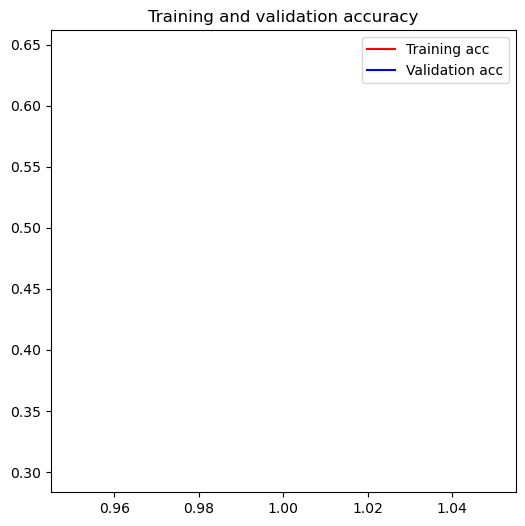

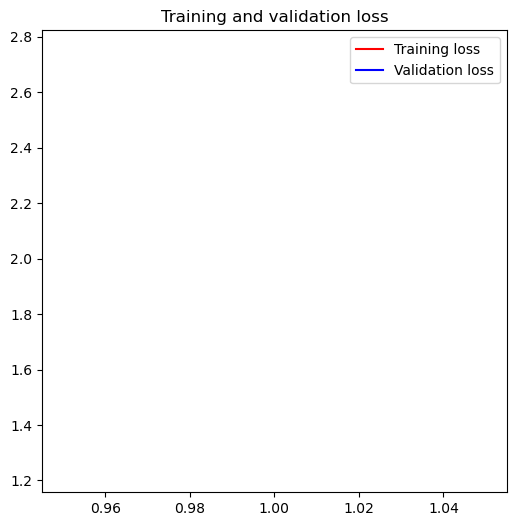

 15/547 [..............................] - ETA: 20:34 - loss: 1.6681 - acc: 0.4875

In [ ]:
epochs_in = 1
train(epochs_in)

## Loading previously saved training data

In [ ]:
model_path = 'trained_model.h5'
history_path = 'training_history.csv'

model, history = load_training_data(model_path, history_path)

## Download and predict images

In [ ]:
download_and_predict("https://cdn.pixabay.com/photo/2016/01/05/17/51/maltese-1123016_960_720.jpg","test_1.jpg")

In [ ]:
download_and_predict("https://t3.ftcdn.net/jpg/01/71/99/74/360_F_171997457_zUbFZOCpqgbdkPRqsrxo2dUAKIZyGTB5.jpg","test_2.jpg")

In [ ]:
download_and_predict("https://www.purina.co.uk/sites/default/files/styles/square_medium_440x440/public/2022-09/Pomeranian.jpg?","test_3.jpg")

In [ ]:
download_and_predict("https://image.petmd.com/files/styles/978x550/public/2023-08/australian-kelpie.jpg","test_4.jpg")

In [ ]:
download_and_predict("https://www.rover.com/blog/wp-content/uploads/2019/12/airedale-terrier.jpg","test_5.jpg")

## Predict images that are already downloaded

In [ ]:
predict("local_test_6.jpeg")

In [ ]:
predict("local_test_7.jpeg")

In [ ]:
predict("local_test_8.jpeg")

## Reform Images
Only needed when new images are put in the dataset

In [ ]:
Image_Reform()

## Start the GUI

In [ ]:
GUI()